В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

Area under ROC score on Train dataset: 0.9019


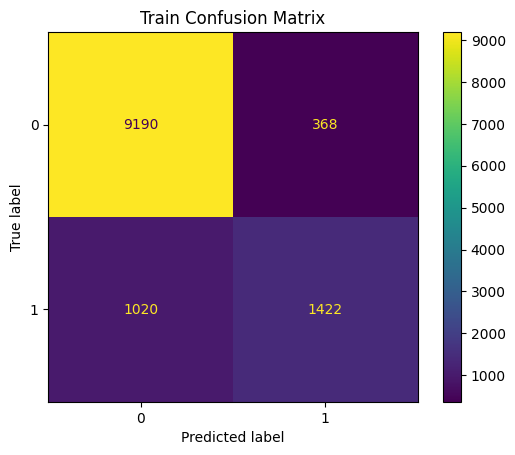

Area under ROC score on Validation dataset: 0.8843


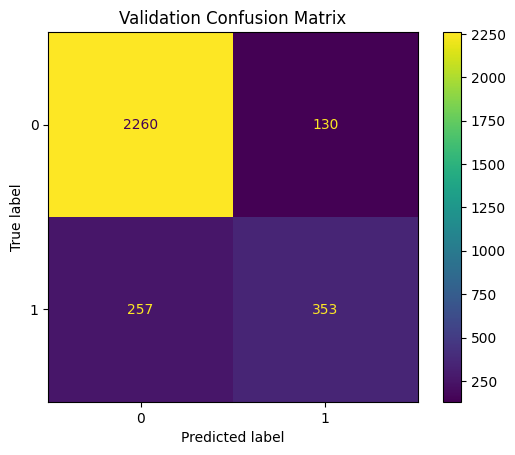

['log_reg_pipeline.joblib']

In [139]:
import os
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    f1_score)
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib

raw_df = pd.read_csv(r'D:\ml_course\Модуль 2. Навчання з учителем\dataframes\bank-customer-churn-prediction-dlu-course-c-4\train.csv', index_col=0)

train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

# Створюємо трен. і вал. набори
input_cols = list(raw_df.columns)[1:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    probs = model_pipeline.predict_proba(inputs)[:, 1]
    roc_auc = roc_auc_score(targets, probs)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.4f}")
    confusion_matrix_ = confusion_matrix(targets, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_)
    disp.plot()
    plt.title(f'{name} Confusion Matrix')
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'log_reg_pipeline.joblib')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

----- BASE MODEL -----

Area under ROC score on Train BASE dataset: 0.9019


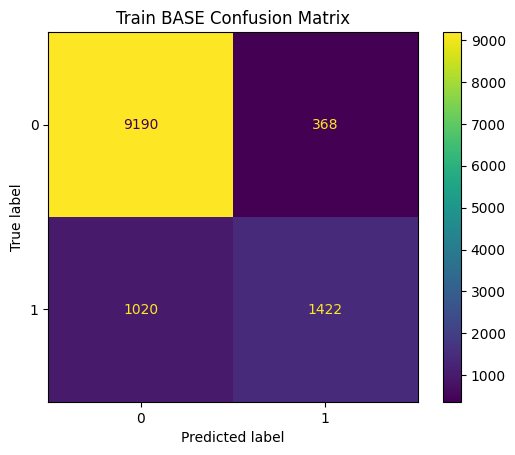

Area under ROC score on Validation BASE dataset: 0.8843


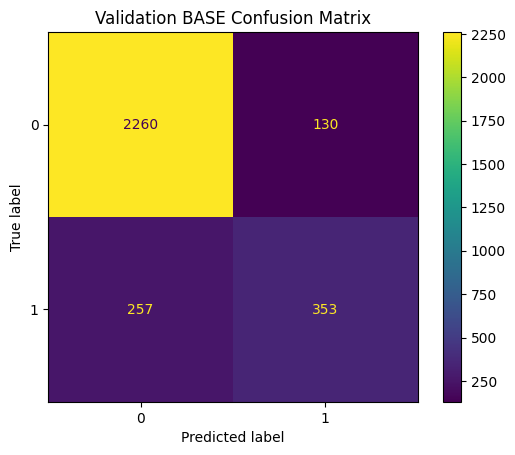

----- POLY MODEL 2 -----

Area under ROC score on Train POLY_2 dataset: 0.9424


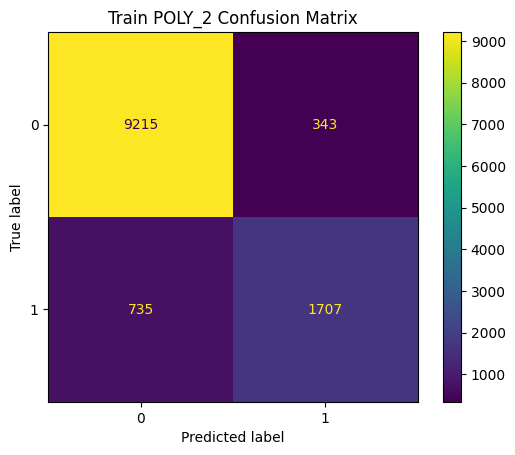

Area under ROC score on Validation POLY_2 dataset: 0.9307


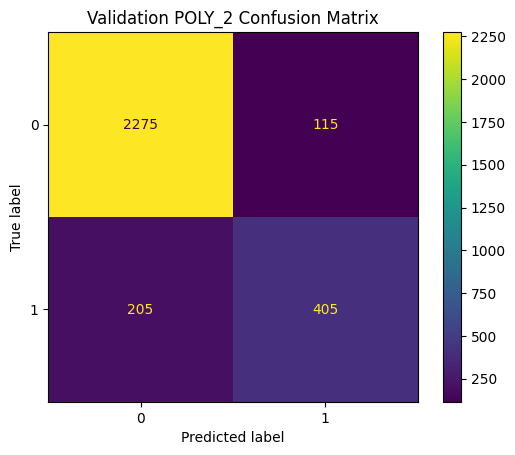

array([1., 0., 0., ..., 0., 0., 0.], shape=(3000,))

In [140]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    f1_score)
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib

raw_df = pd.read_csv(r'D:\ml_course\Модуль 2. Навчання з учителем\dataframes\bank-customer-churn-prediction-dlu-course-c-4\train.csv', index_col=0)

train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

# Створюємо трен. і вал. набори
input_cols = list(raw_df.columns)[1:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

numeric_transformer_poly = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)
model_pipeline_poly.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    probs = model_pipeline.predict_proba(inputs)[:, 1]
    roc_auc = roc_auc_score(targets, probs)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.4f}")
    confusion_matrix_ = confusion_matrix(targets, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_)
    disp.plot()
    plt.title(f'{name} Confusion Matrix')
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
print("----- BASE MODEL -----\n")
predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train BASE')
predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation BASE')

print("----- POLY MODEL 2 -----\n")
predict_and_plot(model_pipeline_poly, train_inputs, train_targets, 'Train POLY_2')
predict_and_plot(model_pipeline_poly, val_inputs, val_targets, 'Validation POLY_2')

Додавання polynomial features суттєво покращило якість моделі. ROC-AUC на валідації зріс з 0.88 до 0.93. Різниця між train та validation невелика приблизно 0.01, що свідчить про покращення моделі та відсутність значного overfit.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

----- BASE MODEL -----

Area under ROC score on Train BASE dataset: 0.9019


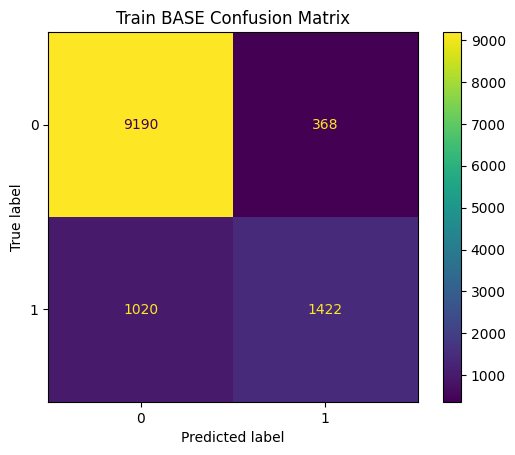

Area under ROC score on Validation BASE dataset: 0.8843


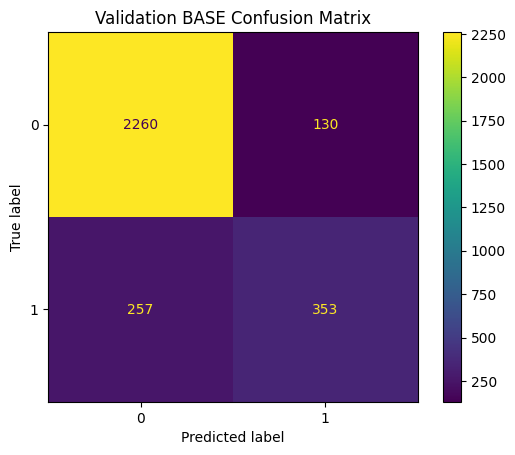

----- POLY MODEL 4 -----

Area under ROC score on Train POLY_4 dataset: 0.9505


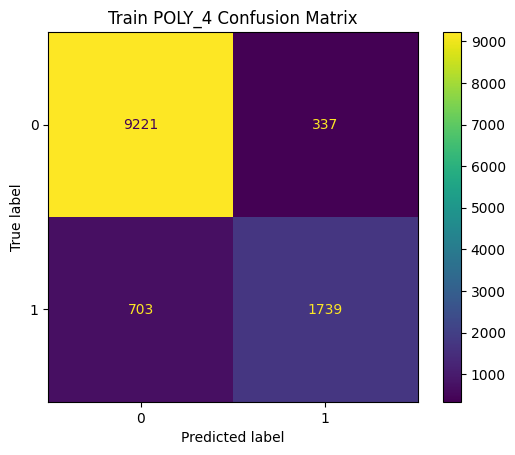

Area under ROC score on Validation POLY_4 dataset: 0.9350


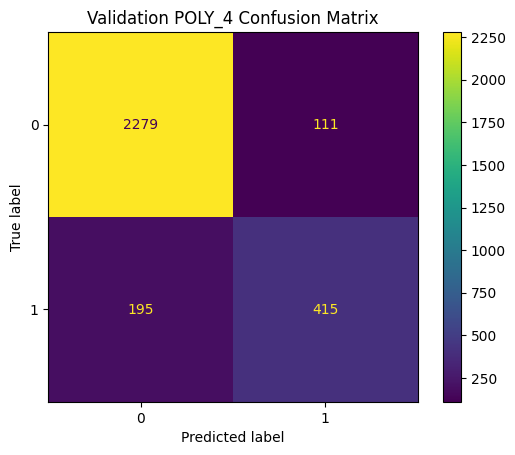

array([1., 0., 0., ..., 0., 0., 0.], shape=(3000,))

In [141]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score)
import matplotlib.pyplot as plt
import joblib

raw_df = pd.read_csv(r'D:\ml_course\Модуль 2. Навчання з учителем\dataframes\bank-customer-churn-prediction-dlu-course-c-4\train.csv', index_col=0)

train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

# Створюємо трен. і вал. набори
input_cols = list(raw_df.columns)[1:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

numeric_transformer_poly_2 = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

preprocessor_poly_2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly_2, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

model_pipeline_poly_2 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly_2),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)
model_pipeline_poly_2.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    probs = model_pipeline.predict_proba(inputs)[:, 1]
    roc_auc = roc_auc_score(targets, probs)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.4f}")
    confusion_matrix_ = confusion_matrix(targets, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_)
    disp.plot()
    plt.title(f'{name} Confusion Matrix')
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
print("----- BASE MODEL -----\n")
predict_and_plot(model_pipeline, train_inputs, train_targets, 'Train BASE')
predict_and_plot(model_pipeline, val_inputs, val_targets, 'Validation BASE')

print("----- POLY MODEL 4 -----\n")
predict_and_plot(model_pipeline_poly_2, train_inputs, train_targets, 'Train POLY_4')
predict_and_plot(model_pipeline_poly_2, val_inputs, val_targets, 'Validation POLY_4')

In [142]:
test_raw_df = pd.read_csv(r'D:\ml_course\Модуль 2. Навчання з учителем\dataframes\bank-customer-churn-prediction-dlu-course-c-4\test.csv',
    index_col=0)
X_test = test_raw_df[input_cols].copy()
test_probs = model_pipeline_poly_2.predict_proba(X_test)[:, 1]

In [143]:
submission_df = pd.read_csv(r'D:\ml_course\Модуль 2. Навчання з учителем\dataframes\bank-customer-churn-prediction-dlu-course-c-4\sample_submission.csv')
submission_df['Exited'] = test_probs
submission_df.head()

,id,Exited
0,15000,0.034344
1,15001,0.025163
2,15002,0.021039
3,15003,0.552382
4,15004,0.017863


In [144]:
submission_df.to_csv('submission_poly4.csv', index=False)

Додавання поліноміальних ознак 4-го степеня покращило якість моделі. ROC-AUC на валідації зріс до 0.935. Різниця між train та validation є невеликою 0.015, що свідчить про відсутність сильного overfit.

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [145]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
reg_df = pd.read_csv(r'D:\ml_course\Модуль 2. Навчання з учителем\dataframes\regression_data.csv')
X = reg_df.drop('target', axis=1)
y = reg_df['target']
X_train_reg, X_test_reg, y_train_reg, y_test_reg  = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
model = make_pipeline(
    PolynomialFeatures(degree=5),
    StandardScaler(),
    LinearRegression())

model.fit(X_train_reg, y_train_reg)

y_train_pred = model.predict(X_train_reg)
y_test_pred = model.predict(X_test_reg)

rmse_train = root_mean_squared_error(y_train_reg, y_train_pred)
rmse_test = root_mean_squared_error(y_test_reg, y_test_pred)

print(f'Train RMSE: {rmse_train:.4f}')
print(f'Test RMSE: {rmse_test:.4f}')

Train RMSE: 0.0000
Test RMSE: 12.6767


При використанні поліноміальних ознак 5-го степеня модель демонструє майже нульову помилку на train вибірці, що свідчить про сильне перенавчання. Помилка на test вибірці значно більша, що означає погану здатність моделі на нових данних. Отже, модель не є хорошо та перенавчається.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [147]:
models = [
    LinearRegression(),
    Ridge(),
    Ridge(alpha=2),
    Lasso(alpha=0.1),
    ElasticNet(),
    ElasticNet(alpha=0.5)
]

In [148]:
def evaluate_model(model, X_train_reg, y_train_reg, X_test_reg, y_test_reg):
    y_train_pred = model.predict(X_train_reg)
    y_test_pred = model.predict(X_test_reg)

    train_metrics = root_mean_squared_error(y_train_reg, y_train_pred)
    val_metrics = root_mean_squared_error(y_test_reg, y_test_pred)

    return dict(train=train_metrics, val=val_metrics)

In [149]:
poly_features = PolynomialFeatures(degree=20)
X_train_reg_poly = poly_features.fit_transform(X_train_reg)
X_test_reg_poly = poly_features.transform(X_test_reg)
scaler = StandardScaler()
X_train_reg_poly = scaler.fit_transform(X_train_reg_poly)
X_test_reg_poly = scaler.transform(X_test_reg_poly)

In [150]:
import warnings
warnings.filterwarnings("ignore")

for model in models:
    model.fit(X_train_reg_poly, y_train_reg)
    eval_results  = evaluate_model(model, X_train_reg_poly, y_train_reg, X_test_reg_poly, y_test_reg)
    print(f'{str(model)}: {eval_results}\n')

LinearRegression(): {'train': 2.5994902001795067e-12, 'val': 65.39118465790204}

Ridge(): {'train': 1.0536700649779418, 'val': 27.797603884437624}

Ridge(alpha=2): {'train': 1.6649927742124488, 'val': 20.61465588439444}

Lasso(alpha=0.1): {'train': 0.9645402862240762, 'val': 1.2770943615313575}

ElasticNet(): {'train': 12.044328017030233, 'val': 20.624001865672057}

ElasticNet(alpha=0.5): {'train': 8.602683447580814, 'val': 17.32988361900436}



Лінійна регресія сильно перенавчається Train  0, Test велике. Ridge та ElasticNet зменшують перенавчання, але найкраще є Lasso.

In [154]:
coefficients = model.coef_
num_nonzero = np.sum(coefficients != 0)
print(f'Кількість ознак що залишилися: {num_nonzero} з {len(coefficients)}.')

Кількість ознак що залишилися: 169 з 53130.


Тут видно що Lasso зануляє більшість поліноміальних ознак і залишає тільки найважливіші. Це пояснює, чому Lasso показує найкращу роботу на тестових даних серед всіх моделей.